In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, cast, Date

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


print("---Measurement------")

inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

print("---Station------")

columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

---Measurement------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
---Station------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

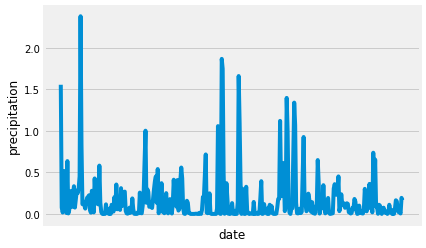

In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

#query the latest date
latest=session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#split the date result and subtract a year
latest_split = str(latest.date).split('-')
year = int(latest_split[0]) - 1
month = latest_split[1]
day = int(latest_split[2])

#rebuild as an f string
yearback = f'{year}-{month}-{day}'

# Perform a query to retrieve the data and precipitation scores

#use the saved dates as strings in the filter 
query = session.query(Measurement.date, func.avg(Measurement.prcp)).\
      filter(Measurement.date < str(latest.date)).filter(Measurement.date > yearback).\
      order_by(Measurement.date).group_by(Measurement.date).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
Precip = pd.DataFrame(query, columns = ["Date","Precipitation"])


# Sort the dataframe by date
Precip.sort_values(by=['Date'])


# Use Pandas Plotting with Matplotlib to plot the data

plt.plot(Precip["Date"],Precip["Precipitation"])

plt.xlabel('date')
plt.ylabel('precipitation')
plt.xticks([])
plt.show()

![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data

Precip["Precipitation"].describe()


count    364.000000
mean       0.170090
std        0.296122
min        0.000000
25%        0.008571
50%        0.070000
75%        0.191667
max        2.380000
Name: Precipitation, dtype: float64

![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).distinct().count()


9

In [35]:
# What are the most active stations? (i.e. what stations have the most rows)?

# List the stations and the counts in descending order.
stationranks = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

for station, count in stationranks:
    print(f'{station}:{count}')

topstation = session.query(Measurement.station).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).first()

topstation.station

USC00519281:2772
USC00519397:2724
USC00513117:2709
USC00519523:2669
USC00516128:2612
USC00514830:2202
USC00511918:1979
USC00517948:1372
USC00518838:511


'USC00519281'

In [36]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


maxt = session.query(func.max(Measurement.tobs)).filter(Measurement.station == topstation.station).all()
mint = session.query(func.min(Measurement.tobs)).filter(Measurement.station == topstation.station).all()
avgt = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == topstation.station).all()

maxtflt = float("{0:.2f}".format(*maxt[0]))
mintflt = float("{0:.2f}".format(*mint[0]))
avgtflt = float("{0:.2f}".format(*avgt[0]))

print(f'For station {topstation.station}: The max temp was {maxtflt}, \
the min temp was {mintflt}, and the average was {avgtflt} ')


For station USC00519281: The max temp was 85.0, the min temp was 54.0, and the average was 71.66 


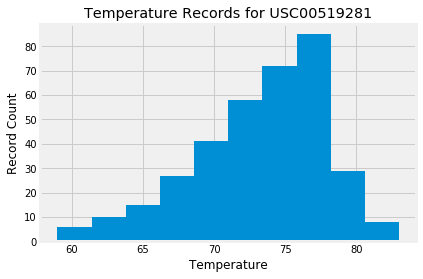

In [37]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


tempdata = session.query(Measurement.tobs, Measurement.date).\
      filter(Measurement.date < str(latest.date)).\
      filter(Measurement.date > yearback).\
      filter(Measurement.station == topstation.station).all()

temp_df = pd.DataFrame(tempdata, columns = ['Temperature', 'Date'])

plt.hist(temp_df['Temperature'])
plt.xlabel('Temperature')
plt.ylabel('Record Count')
plt.title(f'Temperature Records for {topstation.station}')
plt.show()




![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

calcmin = calc_temps(yearback, latest.date)[0][0]
calcavg = calc_temps(yearback, latest.date)[0][1]
calcmax = calc_temps(yearback, latest.date)[0][2]

print(f'min = {calcmin}, avg = {"{0:.2f}".format(calcavg)}, max = {calcmax}')




min = 58.0, avg = 74.59, max = 87.0


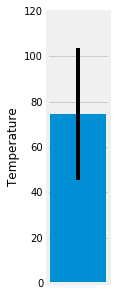

In [38]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

yerr=calcmax - calcmin

plt.figure(figsize=(1,5))
plt.bar(1,calcavg, yerr=yerr, width=1)
plt.ylim(0,120)
plt.ylabel("Temperature")
plt.xticks([])
plt.show()



In [43]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

precipbystation = session.query(Measurement.station, func.sum(Measurement.prcp)).\
group_by(Measurement.station).\
order_by(func.sum(Measurement.prcp).desc()).all()

stationinfo = session.query(Station.station, Station.name, Station.latitude, Station.longitude).all()

precip_df = pd.DataFrame(precipbystation, columns = ['Station', 'Rainfall sum'])
station_df = pd.DataFrame(stationinfo, columns = ["Station", 'Station Name', "latitude", "longitude"])

comb_df = pd.merge(precip_df, station_df, on = "Station", how = 'inner')
comb_df

,Station,Rainfall sum,Station Name,latitude,longitude
0,USC00516128,1068.09,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250
1,USC00519281,588.64,"WAIHEE 837.5, HI US",21.45167,-157.84889
2,USC00513117,382.62,"KANEOHE 838.1, HI US",21.42340,-157.80150
3,USC00519523,295.68,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139
4,USC00514830,234.49,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740
5,USC00519397,131.62,"WAIKIKI 717.2, HI US",21.27160,-157.81680
6,USC00511918,92.68,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920
7,USC00518838,70.87,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110
8,USC00517948,43.44,"PEARL CITY, HI US",21.39340,-157.97510


## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [24]:
# Plot the daily normals as an area plot with `stacked=False`
